In [24]:
# Imports 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# Load the data 

TRAINING_DIRECTORY = "train_files/"
TEST_DIRECTORY = "example_test_files/"

df_stock_prices = pd.read_csv(
    TRAINING_DIRECTORY + "stock_prices.csv", 
    converters = { "ExpectedDividend": lambda x: 1 if x == "True" else 0 })

df_trades = pd.read_csv(TRAINING_DIRECTORY + "trades.csv")
df_stock_list = pd.read_csv("stock_list.csv")

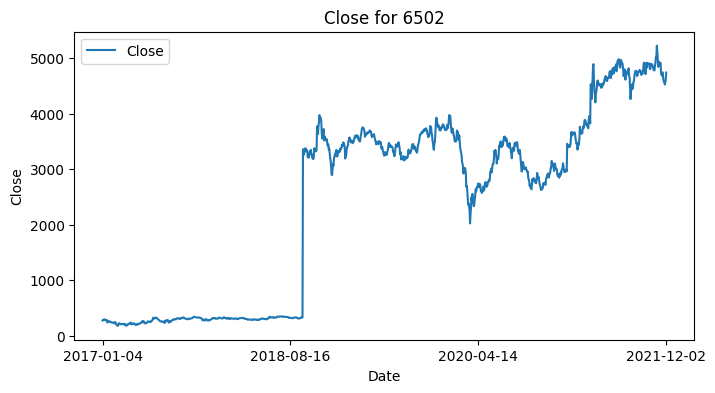

In [3]:
    
def plot_stock_price(securities_code):
    df_stock_prices[df_stock_prices["SecuritiesCode"] == securities_code].plot(x = "Date", y = "Close", figsize=(8,4))
    plt.ylabel("Close")
    plt.title("Close for {}".format(securities_code))
    plt.locator_params(axis='x', nbins=8)
    plt.show()
    

plot_stock_price(6502)

In [43]:
# Matt's Linear Models

stock_price_features = [
    # "Date",
    "SecuritiesCode",
    "Close",
    "Volume",
    "ExpectedDividend",
]
stock_price_target = [ 
    "SecuritiesCode",
    "Target"
]

# Linear Regression

features = df_stock_prices[stock_price_features]
target = df_stock_prices[stock_price_target]

selected_target = target[target["SecuritiesCode"] == 6502].to_numpy(dtype='float', na_value = 0)
selected_target = np.delete(selected_target, obj = 0, axis = 1)

selected_features = features[features["SecuritiesCode"] == 6502].to_numpy(dtype='float', na_value = 0)
selected_features = np.delete(selected_features, obj = 0, axis = 1)

print(selected_features)
print(selected_features.shape)
print()
print(selected_target)

reg = LinearRegression().fit(selected_features, selected_target)
reg.predict(np.array([4690.0, 1368800, 0]).reshape(1, -1))

# Ridge Regression 



# Elastic Net Regression

[[2.77400e+02 3.62027e+08 0.00000e+00]
 [2.90500e+02 2.19540e+08 0.00000e+00]
 [2.87200e+02 1.62399e+08 0.00000e+00]
 ...
 [4.56000e+03 1.72280e+06 0.00000e+00]
 [4.62600e+03 1.52700e+06 0.00000e+00]
 [4.74300e+03 1.84440e+06 0.00000e+00]]
(1202, 3)

[[-0.01135972]
 [ 0.00487465]
 [ 0.04331254]
 ...
 [ 0.02529183]
 [-0.01117436]
 [ 0.01151386]]


array([[0.0001094]])